# PSF Denoising using Anisotropic Smoothing

This notebook sketches the idea of using [anisotropic diffusion](https://en.wikipedia.org/wiki/Anisotropic_diffusion) for denoising PSF histograms. The idea of anisotropic smoothing is that the smoothing scale is adapted to the noise level of the data. If there is more noise the smoothing scale is increased, if the there is less noise in the data, the smoothing scale is chosen smaller.

For the purpose of smoothing PSF histograms of IACTs, the idea is to choose a larger smoothing scale at higher offset angles (wrt. PSF center position) and choose an smoothing scale depending on the exposure for the energy. The goal is to make the PSF histogram numerically more stable for computing reduced PSF images, used in likelihood fitting.

The anisotropic smoothing is applied using matrix multiplication (`np.dot`) and precomputed smoothing matrices with gaussian kernels.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from astropy import units as u
from astropy.visualization import simple_norm

from gammapy.irf import EnergyDependentTablePSF
from gammapy.data import DataStore
from gammapy.irf import make_psf
from gammapy.utils.nddata import sqrt_space

from scipy.ndimage import median_filter, gaussian_filter

## Read Test PSF

In [3]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1")
observations = data_store.get_observations(data_store.obs_table["OBS_ID"])

obs = observations[0]
psf = make_psf(obs, position=obs.pointing_radec)

## Rad Smoothing Matrix

In [4]:
def gaussian(x, mu, sigma):
    """Gaussian model function"""
    return 1 / np.sqrt(2 * np.pi * sigma ** 2) * np.exp(-0.5 * ((x - mu)  / sigma) ** 2)


def get_smoothing_matrix(shape, sigmas):
    """Create smoothing matrix"""
    x, y = np.indices(shape)
    matrix = gaussian(x, mu=y, sigma=sigmas)
    matrix /= matrix.sum(axis=0)
    return matrix

In [5]:
len_energy, len_rad = psf.psf_value.shape

In [6]:
sigma_min, sigma_max = 0.1, 10
sigmas_rad = sqrt_space(sigma_min, sigma_max, len_rad)

Text(0,0.5,'Sigma (pix)')

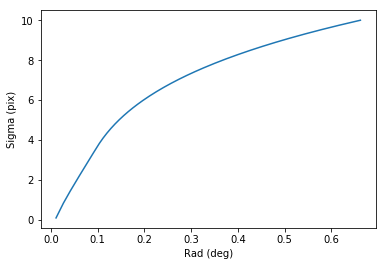

In [7]:
plt.plot(psf.rad.to_value("deg"), sigmas_rad)
plt.xlabel("Rad (deg)")
plt.ylabel("Sigma (pix)")

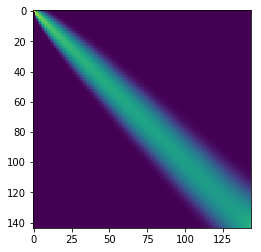

In [8]:
matrix_rad = get_smoothing_matrix(shape=(len_rad, len_rad), sigmas=sigmas_rad)

norm = simple_norm(matrix_rad, stretch="log")
plt.imshow(matrix_rad, norm=norm)

## Energy Smoothing Matrix

In [9]:
# smooth energy axis depending on the exposure
sigma_min, sigma_max = 0.01, 1.5
sigmas_energy = sigma_max * (1. - (psf.exposure / psf.exposure.max())).to_value("") + sigma_min

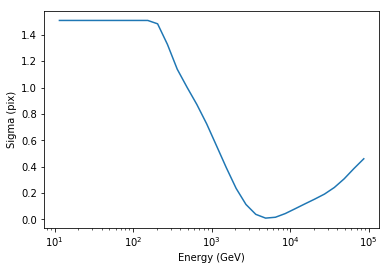

In [10]:
plt.plot(psf.energy, sigmas_energy)
plt.semilogx()
plt.xlabel("Energy (GeV)")
plt.ylabel("Sigma (pix)");

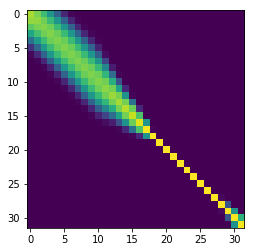

In [11]:
matrix_energy = get_smoothing_matrix(shape=(len_energy, len_energy), sigmas=sigmas_energy)
plt.imshow(matrix_energy, norm=norm)

In [12]:
# smallest possible median filter to remove "hot pixels"
data = median_filter(psf.psf_value.value, 3)

# smooth rad axis
data = np.dot(data, matrix_rad)

# smooth energy axis 
data = np.dot(data.T, matrix_energy).T

In [13]:
psf_value = u.Quantity(data, unit=psf.psf_value.unit)
psf_denoised = EnergyDependentTablePSF(energy=psf.energy, rad=psf.rad, psf_value=psf_value)

## Energy vs. Rad Comparison

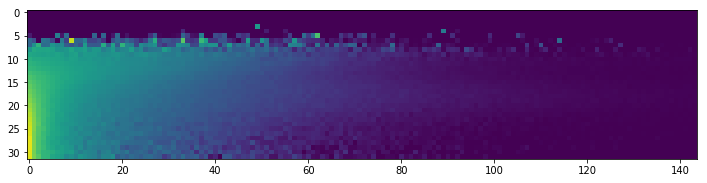

In [14]:
norm_psf = simple_norm(psf.psf_value.value, stretch="log")

plt.figure(figsize=(12, 8))
plt.imshow(psf.psf_value.value, norm=norm_psf, vmax=1e6)

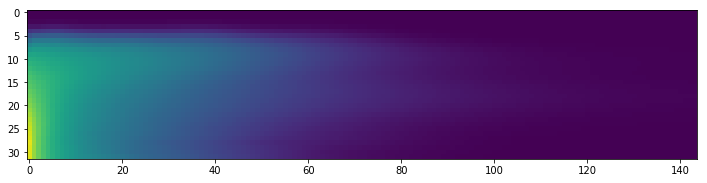

In [15]:
plt.figure(figsize=(12, 8))
plt.imshow(psf_denoised.psf_value.value, norm=norm_psf, vmax=1e6)

## Containment Radius Comparison

In [16]:
def get_containment_radius(psf, c=0.8):
    from scipy.integrate import cumtrapz
    
    x = psf.rad.to_value("deg")
    y = x * psf.psf_value.to_value("deg-2")
    data = cumtrapz(y=y, x=x, axis=1)
    
    with np.errstate(invalid="ignore"):
        containment = data / data[:, -1][:, np.newaxis]
    
    return psf.rad[np.argmin(np.abs(containment - c), axis=-1)].to("deg")
    

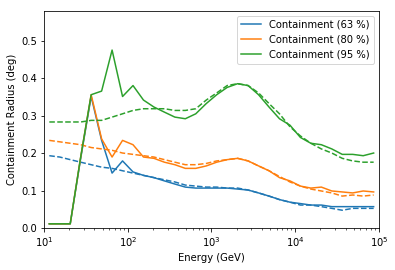

In [17]:
for c in [0.63, 0.8, 0.95]:
    containment_radius = get_containment_radius(psf, c=c)
    lines = plt.plot(psf.energy, containment_radius, label="Containment ({:.0f} %)".format(100 * c))
    
    containment_radius = get_containment_radius(psf_denoised, c=c)
    plt.plot(psf.energy, containment_radius, color=lines[0].get_color(), ls="--")
    
    
plt.semilogx()
plt.xlim(1e1, 1e5)
plt.ylim(0, 0.58)
plt.legend(loc="upper right")
plt.xlabel("Energy (GeV)")
plt.ylabel("Containment Radius (deg)");

## Shape Comparison

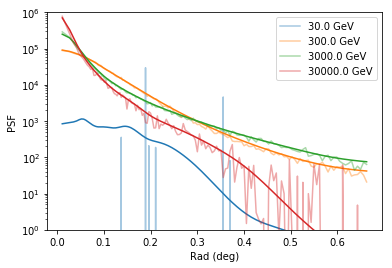

In [18]:
for energy in [30, 300, 3000, 30000] * u.GeV:
    vals = psf.evaluate(energy=energy)
    lines = plt.plot(psf.rad.to("deg"), vals[0], label="{}".format(energy), alpha=0.4)
    
    vals = psf_denoised.evaluate(energy=energy)
    plt.plot(psf.rad.to("deg"), vals[0], color=lines[0].get_color())

plt.ylim(1, 1e6)
plt.semilogy()
#plt.semilogx()
plt.xlabel("Rad (deg)")
plt.ylabel("PSF")
plt.legend()